In [1]:
import gzip
from Bio import SeqIO


In [102]:
flagstat = '/Users/rjing/Desktop/flagstat.txt'

def get_fastq_index_length(fastq_file):
    with open(fastq_file, "r") as f:
        first_line = f.readline().strip()
        index_length = len(first_line.split(":")[-1])
    return index_length


def get_fastq_read_length(fastq_file):
    with open(fastq_file, "r") as f:
        for line in f:
            if line.startswith("@"):
                read_length = len(f.readline().strip())
                return read_length

# Usage
fastq_file = "/Users/rjing/Desktop/test/input_data/read2.fastq"
read_length = get_fastq_read_length(fastq_file)
print(read_length)

index_length = get_fastq_index_length(fastq_file)
print(index_length)





300
12


In [2]:

def estimate_unique_molecules(fastq_file_1, fastq_file_2):
    sequences = set()
    total_reads = 0

    # Iterate over the paired FASTQ files and collect unique sequences
    with gzip.open(fastq_file_1, "rt") as handle_1, gzip.open(fastq_file_2, "rt") as handle_2:
        for record_1, record_2 in zip(SeqIO.parse(handle_1, "fastq"), SeqIO.parse(handle_2, "fastq")):
            sequences.add((str(record_1.seq), str(record_2.seq)))
            total_reads += 1

    unique_molecules = len(sequences)

    return unique_molecules, total_reads

# Provide the paths to your paired gzipped FASTQ files
fastq_file_path_1 = "/Users/rjing/Desktop/test/input/read1.fastq.gz"
fastq_file_path_2 = "/Users/rjing/Desktop/test/input/read2.fastq.gz"

# Call the function to estimate the number of unique molecules
unique_molecules, total_reads = estimate_unique_molecules(fastq_file_path_1, fastq_file_path_2)

print("Total Reads:", total_reads)
print("Unique Molecules:", unique_molecules)


Total Reads: 100000
Unique Molecules: 99942


In [3]:
import gzip
import numpy as np
from Bio import SeqIO

def calculate_insert_sizes(fastq_file1, fastq_file2):
    insert_sizes = []

    with gzip.open(fastq_file1, "rt") as handle1, gzip.open(fastq_file2, "rt") as handle2:
        for record1, record2 in zip(SeqIO.parse(handle1, "fastq"), SeqIO.parse(handle2, "fastq")):
            insert_size = len(record2.seq) - len(record1.seq)
            insert_sizes.append(insert_size)

    return insert_sizes

# Provide the paths to your paired gzipped FASTQ files after adapter removal
fastq_file_path_1 = "/Users/rjing/Desktop/test/input/read1.fastq.gz"
fastq_file_path_2 = "/Users/rjing/Desktop/test/input/read2.fastq.gz"

# Call the function to calculate insert sizes
insert_sizes = calculate_insert_sizes(fastq_file_path_1, fastq_file_path_2)

# Calculate mean and standard deviation
mean_insert_size = np.mean(insert_sizes)
std_insert_size = np.std(insert_sizes)

print("Mean Insert Size:", mean_insert_size)
print("Standard Deviation of Insert Size:", std_insert_size)


Mean Insert Size: 0.0
Standard Deviation of Insert Size: 0.0


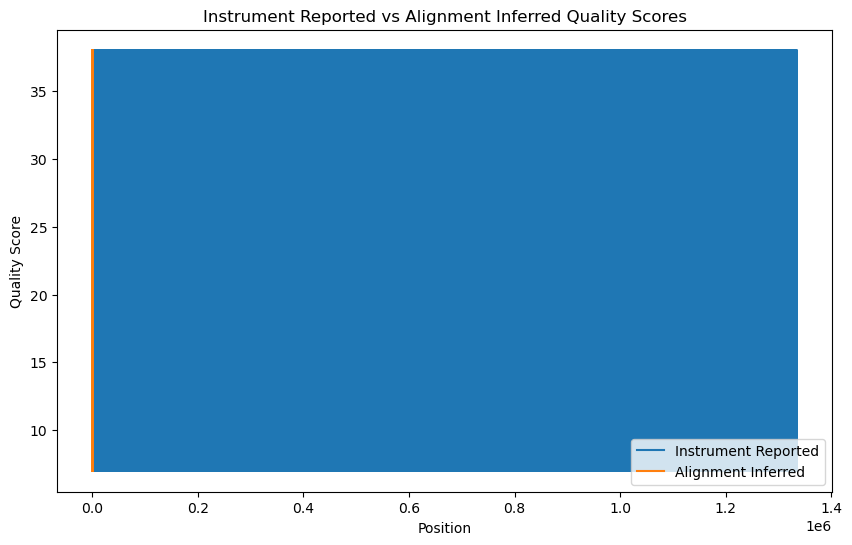

In [33]:
import pysam
import matplotlib.pyplot as plt

# Increase chunk size
plt.rcParams['agg.path.chunksize'] = 1000


# Path to your SAM file
sam_file = "/Users/rjing/Desktop/trim_read1_read2_alig.sam"

# Path to your FASTQ file
fastq_file = "/Users/rjing/Desktop/trim_read1_paired.fastq"

# Read Phred scores from SAM file
sam_positions = []
sam_scores = []
with open(sam_file, "r") as sam:
    for line in sam:
        if line.startswith("@"):
            continue
        fields = line.strip().split("\t")
        positions = range(int(fields[3]), int(fields[3]) + len(fields[9]))
        scores = [ord(ch) - 33 for ch in fields[10]]
        sam_positions.extend(positions)
        sam_scores.extend(scores)

# Read Phred scores from FASTQ file
fastq_positions = []
fastq_scores = []
with open(fastq_file, "r") as fastq:
    for i, line in enumerate(fastq):
        if i % 4 == 3:
            scores = [ord(ch) - 33 for ch in line.strip()]
            fastq_positions.extend(range(len(scores)))
            fastq_scores.extend(scores)

# Create a data frame with the position, Phred scores, and quality scores
data = {
    "SAM_Position": sam_positions,
    "SAM_Score": sam_scores,
    "FASTQ_Position": fastq_positions,
    "FASTQ_Score": fastq_scores,
}

# Plot instrument-reported Phred scores and alignment inferred quality scores
plt.figure(figsize=(10, 6))
plt.plot(data["SAM_Position"], data["SAM_Score"], label="Instrument Reported")
plt.plot(data["FASTQ_Position"], data["FASTQ_Score"], label="Alignment Inferred")
plt.xlabel("Position")
plt.ylabel("Quality Score")
plt.title("Instrument Reported vs Alignment Inferred Quality Scores")
plt.legend()
plt.show()


In [47]:
import pysam

# Open the BAM file
bam_file = pysam.AlignmentFile('/Users/rjing/Desktop/trim_read1_read2_alig.sam', 'rb')

# Get the header information
header = bam_file.header

# Extract the sequencing configuration
read1_len = None
index1_len = None
index2_len = None
read2_len = None

for rg_dict in header.get('RG', []):
    if 'ID' in rg_dict and rg_dict['ID'] == '1':
        if 'S' in rg_dict and rg_dict['S'] == 'read1':
            read1_len = rg_dict.get('CN', None)
    elif 'ID' in rg_dict and rg_dict['ID'] == '2':
        if 'S' in rg_dict and rg_dict['S'] == 'index1':
            index1_len = rg_dict.get('CN', None)
        elif 'S' in rg_dict and rg_dict['S'] == 'index2':
            index2_len = rg_dict.get('CN', None)
        elif 'S' in rg_dict and rg_dict['S'] == 'read2':
            read2_len = rg_dict.get('CN', None)

# Print the sequencing configuration
print('Read 1 Length:', read1_len)
print('Index 1 Length:', index1_len)
print('Index 2 Length:', index2_len)
print('Read 2 Length:', read2_len)

# Close the BAM file
bam_file.close()


Read 1 Length: None
Index 1 Length: None
Index 2 Length: None
Read 2 Length: None
